<a href="https://colab.research.google.com/github/MonkeyWrenchGang/2021-ban7002/blob/main/Week_5_MeanTweetsAndWordClouds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Term Frequency


---

Term  & nGram frequency analysis are natural language processing (NLP)  technique used to extract insights from textual data. The basic idea behind term frequency analysis is simple: the more often a word or phrase appears in a text, the more important it is likely to be. By counting the frequency of each word or phrase in the text, we can build a list of the most common terms and gain insights into the topics and themes that are most prevalent in the text.

Our basic recipe:

1. import the data containing text
2. parse the text into words
  - convert words to lower case
  - remove punctuation
  - remove stopwords and other excludes
3. count up the words
  - display top n words
  - make a barchart
  - make a wordcloud


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# standard libries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# text libraries
import nltk
from nltk.util import ngrams
from nltk import bigrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import string
from textblob import TextBlob
from wordcloud import WordCloud


In [ ]:
# dlownload nltk datasets
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Trump's Tweets


---

Donald Trump's Twitter archive is a comprehensive record of the tweets made by Donald Trump, the 45th President of the United States, from his account @realDonaldTrump. Trump was known for his active presence on Twitter, using the platform to make policy announcements, criticize opponents, and communicate directly with the public. His tweets have been a subject of controversy and discussion throughout his presidency.

The archive includes tweets from the time he joined Twitter in March 2009 to January 2021, when his account was permanently suspended by Twitter due to "the risk of further incitement of violence" following the storming of the U.S. Capitol by his supporters.



In [ ]:
tweets = pd.read_csv("https://raw.githubusercontent.com/MonkeyWrenchGang/2023_BAN6005/main/module_5/data/trump_tweets.csv",
                     parse_dates=["tweet_date"])
tweets['tweet_date'] = tweets['tweet_date'].dt.date
tweets.head(5)

,tweet_id,tweet_text,is_retweet,is_deleted,device,favorites,retweets,tweet_timestamp,is_flagged,tweet_date
0,9.845500e+16,Republicans and Democrats have both created ou...,False,False,TweetDeck,49,255,2011-08-02T18:07:48Z,False,2011-08-02
1,1.234650e+18,I was thrilled to be back in the Great city of...,False,False,Twitter for iPhone,73748,17404,2020-03-03T01:34:50Z,False,2020-03-03
2,1.218010e+18,RT @CBS_Herridge: READ: Letter to surveillance...,True,False,Twitter for iPhone,0,7396,2020-01-17T03:22:47Z,False,2020-01-17
3,1.304880e+18,The Unsolicited Mail In Ballot Scam is a major...,False,False,Twitter for iPhone,80527,23502,2020-09-12T20:10:58Z,False,2020-09-12
4,1.220000e+18,RT @MZHemingway: Very friendly telling of even...,True,False,Twitter for iPhone,0,9081,2020-01-17T13:13:59Z,False,2020-01-17


# Stopwords
---


Stopwords are commonly occurring words in natural language that carry **little meaning** on their own and are typically removed from text during preprocessing. Examples of stopwords in English include "the", "and", "of", "a", "in", and "to".


In [ ]:
# Define the stop words to remove
stop_words = set(stopwords.words('english'))

# Convert the set to a DataFrame
stopwords_df = pd.DataFrame(list(stop_words), columns=['stopword'])
print("There are {} words in the stopword list here is a sample: \n {}".format(stopwords_df.shape[0],list(stop_words)[0:4]))



There are 179 words in the stopword list here is a sample: 
 ['ll', 'as', 'own', 'more']


# Excludes
---

Like stopwords, excludes are commonly occuring no to low value words that you need to remove based on the TEXT you are analyzing.


In [ ]:
exclude_words = ["t.co", "https", "rt","iphone", "amp", "android", "it's", " ", "_", "-"]

exclude_df = pd.DataFrame(list(exclude_words), columns=['stopword'])
exclude_df.head()

,stopword
0,t.co
1,https
2,rt
3,iphone
4,amp


# Bigram


---

Bigrams are used to capture the relationships between adjacent words or characters in a sequence. Ever wonder how those type-ahead things work? they are fancy n-gram models which predict the next word in a sequence, bigrams and n-grams are the foundation of how these models work.

> A bigram is a pair of consecutive words in a text. For example, in the sentence "I love ice cream," the bigrams are (I, love), (love, ice), and (ice, cream). Bigrams provide a simple way to capture some of the context and dependencies between words, identifing common phrases or collocations, i.e., groups of words that frequently occur together.

An n-gram is a more generalized concept, representing a contiguous **sequence** of n items from a given text or speech. The items can be characters,  words, or even phrases, depending on the context.


# My prefered way...


---

My way explodes the bigrams into rows of a table which can easily be counted up and prepared.

In [ ]:
import string
# Get all punctuation
all_punctuation = string.punctuation

# Remove '@' from the string of punctuation
punctuation_without_at = all_punctuation.replace('@', '')


In [ ]:
ngram_size = 2

# Extract bi-grams from the "full_text" column
bigram_df = (tweets['tweet_text']
             .str.lower()
             .str.replace(f"[{punctuation_without_at}]", "", regex=True) # Remove punctuation except @
             .str.split()
             .apply(lambda x: list(ngrams(x, ngram_size))) # Extract bi-grams
             .explode()
             .reset_index(drop=True)
             .to_frame('bigram')
          )
bigram_df.head()

,bigram
0,"(republicans, and)"
1,"(and, democrats)"
2,"(democrats, have)"
3,"(have, both)"
4,"(both, created)"


In [ ]:
# Count the bigrams
bigram_freq = (bigram_df.groupby("bigram")
                     .agg(freq=("bigram", "count"))
                     .reset_index()
                     .sort_values("freq", ascending=False)
                     .dropna()
                     .reset_index(drop=True)
            )
# eyeball them
bigram_freq.head()

,bigram,freq
0,"(of, the)",4137
1,"(thank, you)",3379
2,"(in, the)",3131
3,"(will, be)",2863
4,"(is, a)",2115


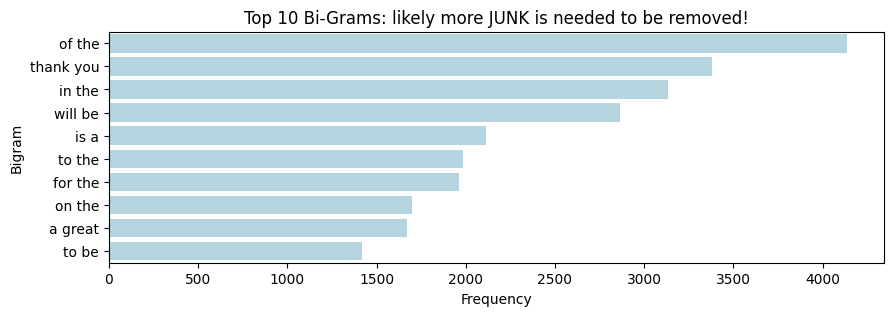

In [ ]:
# Create bar plot of top 5 terms
bigram_freq['bigram_str'] = bigram_freq['bigram'].apply(lambda x: ' '.join(x))

plt.figure(figsize=(10, 3))
sns.barplot(x="freq", y="bigram_str", data=bigram_freq.head(10), color="lightblue")
plt.title('Top 10 Bi-Grams: likely more JUNK is needed to be removed!')
plt.xlabel('Frequency')
plt.ylabel('Bigram');

In [ ]:
# get a list of stop words
exclude_list = ['rt','amp']
stop_words = list(set(stopwords.words('english'))) + exclude_list

# remove any nulls
bigram_freq = bigram_freq.dropna()

# create a new column with stop words removed
bigram_freq['bigram_wo_stopwords'] = bigram_freq['bigram'].apply(lambda x: ' '.join([word for word in x if pd.notna(word) and word.lower() not in stop_words]))

bigram_freq.head()

,bigram,freq,bigram_str,bigram_wo_stopwords
0,"(of, the)",4137,of the,
1,"(thank, you)",3379,thank you,thank
2,"(in, the)",3131,in the,
3,"(will, be)",2863,will be,
4,"(is, a)",2115,is a,


In [ ]:
# select only bigrams that contain two words
bigram_freq = bigram_freq[bigram_freq['bigram_wo_stopwords'].str.split().str.len() == 2].reset_index(drop=True)
bigram_freq.head(10)

,bigram,freq,bigram_str,bigram_wo_stopwords
0,"(donald, trump)",1010,donald trump,donald trump
1,"(fake, news)",963,fake news,fake news
2,"(united, states)",716,united states,united states
3,"(america, great)",707,america great,america great
4,"(make, america)",665,make america,make america
5,"(president, @realdonaldtrump)",636,president @realdonaldtrump,president @realdonaldtrump
6,"(white, house)",516,white house,white house
7,"(new, york)",516,new york,new york
8,"(mr, trump)",504,mr trump,mr trump
9,"(president, trump)",482,president trump,president trump


## Split into two words

In [ ]:
bigram_freq[['term1','term2']] = bigram_freq['bigram_wo_stopwords'].str.split(expand=True)
bigram_freq.head()

,bigram,freq,bigram_str,bigram_wo_stopwords,term1,term2
0,"(donald, trump)",1010,donald trump,donald trump,donald,trump
1,"(fake, news)",963,fake news,fake news,fake,news
2,"(united, states)",716,united states,united states,united,states
3,"(america, great)",707,america great,america great,america,great
4,"(make, america)",665,make america,make america,make,america


## Words after "Fake"

In [ ]:
fake_mask = bigram_freq['term1']=="fake"
res1 = bigram_freq[fake_mask].nlargest(10,'freq')
res1

,bigram,freq,bigram_str,bigram_wo_stopwords,term1,term2
1,"(fake, news)",963,fake news,fake news,fake,news
674,"(fake, dossier)",25,fake dossier,fake dossier,fake,dossier
811,"(fake, media)",22,fake media,fake media,fake,media
2958,"(fake, reporting)",8,fake reporting,fake reporting,fake,reporting
3025,"(fake, story)",8,fake story,fake story,fake,story
3494,"(fake, whistleblower)",7,fake whistleblower,fake whistleblower,fake,whistleblower
3512,"(fake, polls)",7,fake polls,fake polls,fake,polls
4347,"(fake, ballots)",6,fake ballots,fake ballots,fake,ballots
4528,"(fake, suppression)",6,fake suppression,fake suppression,fake,suppression
5314,"(fake, witch)",5,fake witch,fake witch,fake,witch


Text(0.5, 1.0, 'Bigrams Starting w. Fake')

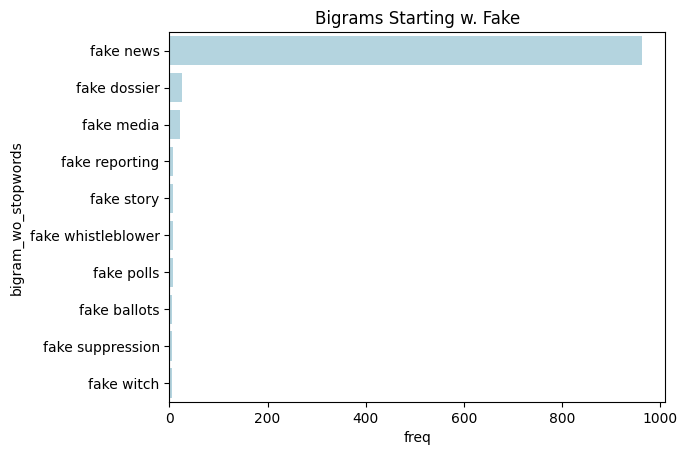

In [ ]:
sns.barplot(data=res1,
            y='bigram_wo_stopwords',
            x='freq',
            color='lightblue'
            )
plt.title("Bigrams Starting w. Fake")

Text(0.5, 1.0, 'Bigrams containing w. Fake')

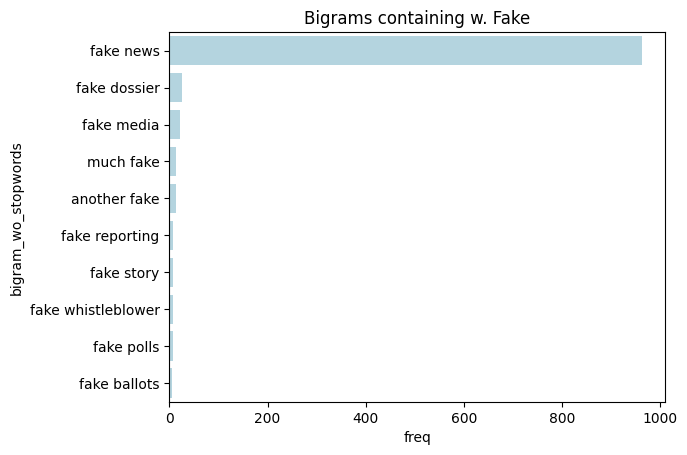

In [ ]:
fake_mask = bigram_freq['bigram_wo_stopwords'].str.contains("fake")
res2 = bigram_freq[fake_mask].nlargest(10,'freq')
res2

sns.barplot(data=res2,
            y='bigram_wo_stopwords',
            x='freq',
            color='lightblue'
            )
plt.title("Bigrams containing w. Fake")